In [67]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 9)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [4]:
# HIDDEN
def plot_loss(y_vals, xlim, loss_fn):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(5, 3))
    plt.plot(thetas, losses, zorder=1)
    plt.xlim(*xlim)
    plt.title(loss_fn.__name__)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Loss')
    
def plot_theta_on_loss(y_vals, theta, loss_fn, **kwargs):
    loss = loss_fn(theta, y_vals)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([theta], [loss], **{**default_args, **kwargs})

def plot_tangent_on_loss(y_vals, theta, loss_fn, eps=1e-6):
    slope = ((loss_fn(theta + eps, y_vals) - loss_fn(theta - eps, y_vals))
             / (2 * eps))
    xs = np.arange(theta - 1, theta + 1, 0.05)
    ys = loss_fn(theta, y_vals) + slope * (xs - theta)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')

## Batch Gradient Descent

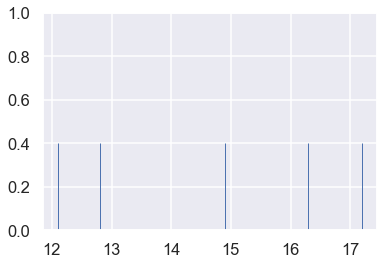

In [9]:
pts = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
sns.rugplot(pts, height=0.4)

In [10]:
def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

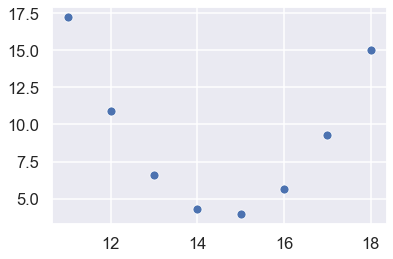

In [12]:
thetas = np.arange(11, 19, 1)
mses = [mse(theta, pts) for theta in thetas]
sns.scatterplot(thetas, mses);

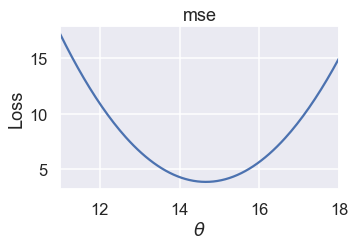

In [13]:
plot_loss(pts, (11, 18), mse)

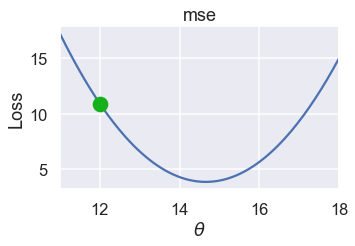

In [14]:
start = 12
plot_loss(pts, (11, 18), mse)
plot_theta_on_loss(pts, start, mse)

In [5]:
def grad_mse(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

In [16]:
def grad_descent_one(theta, y_vals, grad_loss, alpha=0.3):
    return theta - alpha * grad_loss(theta, y_vals)

In [18]:
grad_descent_one(start, pts, grad_mse)

13.596

In [25]:
def plot_one_gd_iter(y_vals, theta, loss_fn, grad_loss, alpha=0.3):
    new_theta = grad_descent_one(theta, y_vals, grad_loss, alpha)
    plot_loss(pts, (11, 18), loss_fn)
    plot_theta_on_loss(pts, theta, loss_fn, c='none',
                       edgecolor=sns.xkcd_rgb['green'], linewidth=2)
    plot_theta_on_loss(pts, new_theta, loss_fn)
    print(f'old theta: {theta}')
    print(f'new theta: {new_theta}')

old theta: 12
new theta: 13.596


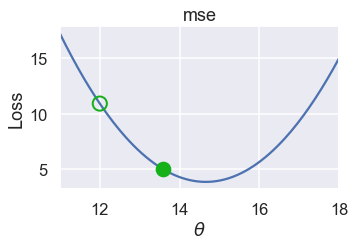

In [20]:
plot_one_gd_iter(pts, start, mse, grad_mse)

old theta: 13.6
new theta: 14.236


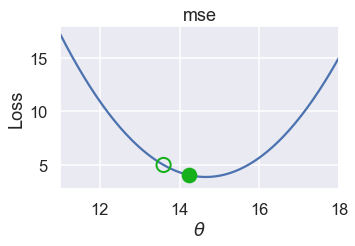

In [21]:
plot_one_gd_iter(pts, 13.6, mse, grad_mse)

old theta: 14.5
new theta: 14.596


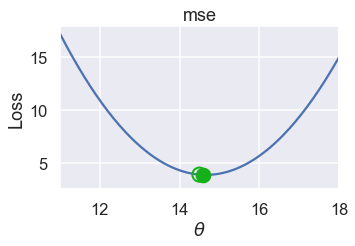

In [23]:
plot_one_gd_iter(pts, 14.5, mse, grad_mse)

In [24]:
np.mean(pts)

14.66

## Adjusting the Learning Rate

In [48]:
def plot_n_gd_iter(n, y_vals, theta, loss_fn, grad_loss, alpha=0.3):
    for _ in range(n):
        new_theta = grad_descent_one(theta, y_vals, grad_loss, alpha)
        plot_loss(pts, (11, 18), loss_fn)
        plot_theta_on_loss(pts, theta, loss_fn, c='none',
                           edgecolor=sns.xkcd_rgb['green'], linewidth=2)
        plot_theta_on_loss(pts, new_theta, loss_fn)
        theta = new_theta
        plt.show()

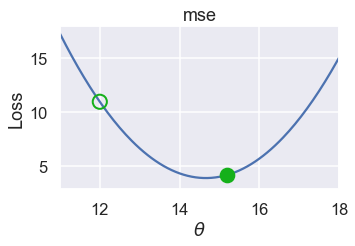

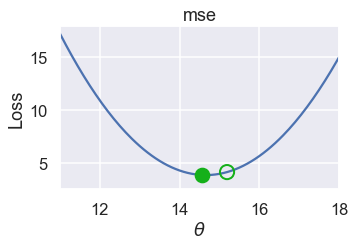

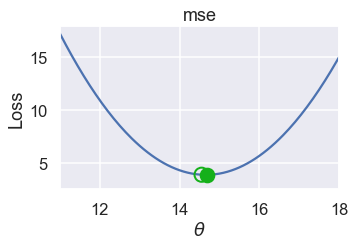

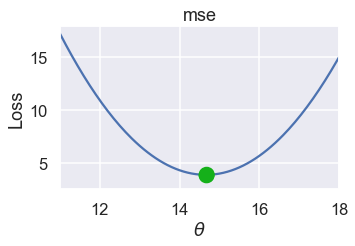

In [53]:
alpha = 0.6
plot_n_gd_iter(4, pts, start, mse, grad_mse, alpha)

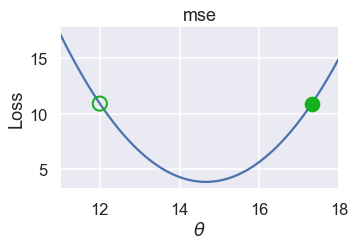

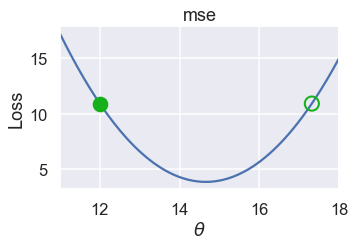

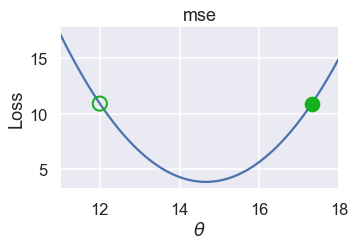

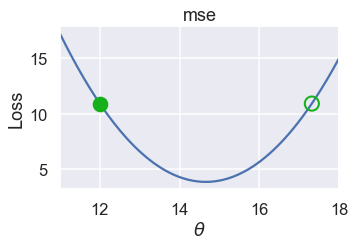

In [49]:
alpha = 1
plot_n_gd_iter(4, pts, start, mse, grad_mse, alpha)

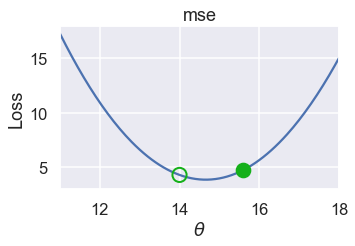

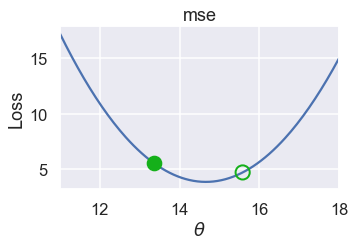

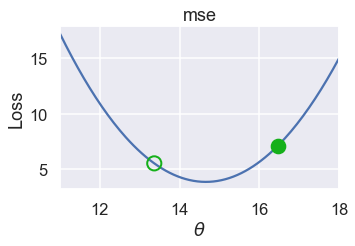

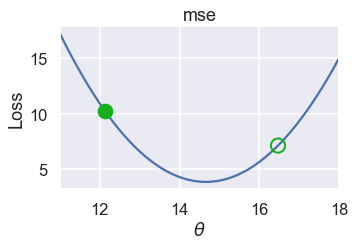

In [50]:
alpha = 1.2
plot_n_gd_iter(4, pts, 14, mse, grad_mse, alpha)

## Fitting a Linear Model

In [321]:
from scipy.optimize import minimize as sci_min
def minimize(loss_fn, grad_loss_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize loss_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return loss_fn(theta, X, y)
    def gradient(theta):
        return grad_loss_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress:
            print(f'theta: {theta} | loss: {loss_fn(theta, X, y):.2f}')
        iters += 1

    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

In [322]:
mpg = sns.load_dataset('mpg').dropna()
mpg

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
...,...,...,...,...,...,...,...,...,...
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger
397,31.0,4,119.0,82.0,2720,19.4,82,usa,chevy s-10


In [323]:
cols = ['bias', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
X = mpg.assign(bias=1)[cols].values
y = mpg['mpg'].values

In [324]:
def linear_model(thetas, X):
    '''Returns predictions by a linear model on x_vals.'''
    return X @ thetas

In [325]:
def mse_loss(thetas, X, y):
    return np.mean((y - linear_model(thetas, X)) ** 2)

In [326]:
def grad_mse_loss(thetas, X, y):
    n = len(X)
    return -2 / n * (X.T @ y - X.T @ X @ thetas)

In [327]:
thetas = minimize(mse_loss, grad_mse_loss, X, y)
thetas

theta: [0.   0.   0.   0.   0.01 0.   0.  ] | loss: 179.38
theta: [ 0.    0.   -0.16 -0.02  0.02  0.02  0.09] | loss: 65.59
theta: [ 0.01  0.01 -0.04  0.12 -0.01  0.09  0.49] | loss: 17.13
theta: [ 0.01  0.01  0.   -0.01 -0.01  0.11  0.56] | loss: 12.06
theta: [-0.   -0.03  0.   -0.02 -0.01 -0.07  0.6 ] | loss: 11.94
theta: [-0.05 -0.33  0.01 -0.02 -0.01 -0.06  0.61] | loss: 11.88
theta: [-0.12 -0.53  0.01 -0.02 -0.01 -0.05  0.61] | loss: 11.87
theta: [-0.34 -0.59  0.01 -0.02 -0.01 -0.05  0.62] | loss: 11.86
theta: [-0.79 -0.64  0.01 -0.02 -0.01 -0.04  0.62] | loss: 11.85
theta: [-1.64 -0.68  0.01 -0.02 -0.01 -0.03  0.63] | loss: 11.82
theta: [-3.31 -0.72  0.01 -0.02 -0.01 -0.01  0.65] | loss: 11.77
theta: [-6.72 -0.73  0.01 -0.01 -0.01  0.02  0.68] | loss: 11.70
theta: [-13.59  -0.62   0.01  -0.    -0.01   0.09   0.75] | loss: 11.61
theta: [-14.63  -0.51   0.01  -0.    -0.01   0.09   0.76] | loss: 11.60
theta: [-14.85  -0.34   0.01   0.    -0.01   0.09   0.76] | loss: 11.59
theta: [-1

array([-14.54,  -0.33,   0.01,  -0.  ,  -0.01,   0.09,   0.75])

In [306]:
def fit_linear(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y
fit_linear(X, y)

array([-14.54,  -0.33,   0.01,  -0.  ,  -0.01,   0.09,   0.75])

In [328]:
mse_loss(fit_linear(X, y), X, y)

11.590170981415225

In [329]:
mse_loss(thetas, X, y)

11.590170981415227

Let's take a peek inside GD:

In [330]:
cols = ['bias', 'horsepower']
X = mpg.assign(bias=1)[cols].values
y = mpg['mpg'].values

In [331]:
thetas = minimize(mse_loss, grad_mse_loss, X, y)
thetas

theta: [0.   0.18] | loss: 214.13
theta: [9.53 0.1 ] | loss: 134.23
theta: [31.78 -0.09] | loss: 31.88
theta: [39.94 -0.16] | loss: 23.94


array([39.94, -0.16])

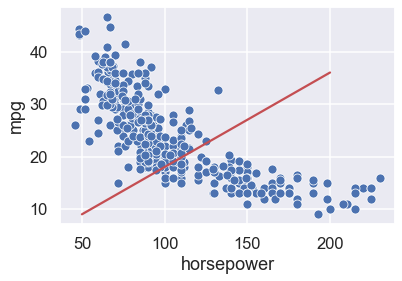

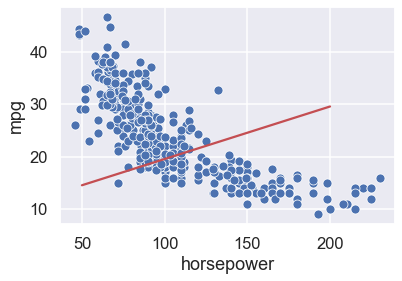

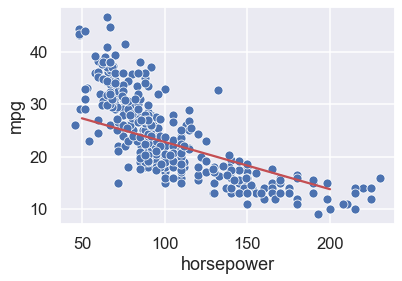

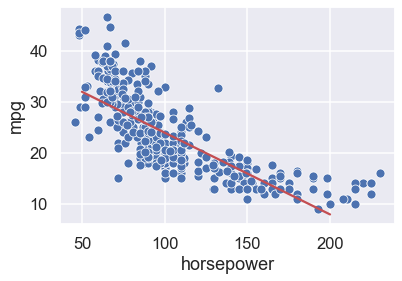

In [337]:
history = np.array([
    [0.,    0.18],
    [9.53,  0.1 ],
    [31.78, -0.09],
    [39.94, -0.16],
])

for b, a in history:
    xs = np.array([50, 200])
    ys = a * xs + b
    sns.scatterplot('horsepower', 'mpg', data=mpg)
    plt.plot(xs, ys, c='r')
    plt.show()

## Stochastic Gradient Descent

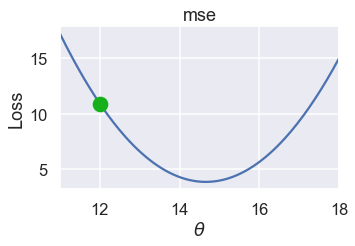

In [338]:
start = 12
plot_loss(pts, (11, 18), mse)
plot_theta_on_loss(pts, start, mse)

In [342]:
def grad_mse_one(pt, theta):
    return -2 * (pt - theta)

In [346]:
def plot_sgd_epoch(y_vals, theta, loss_fn, grad_one, alpha=0.3):
    shuffled = np.random.choice(y_vals, size=len(y_vals), replace=False)
    for pt in shuffled:
        new_theta = theta - alpha * grad_one(pt, theta)
        plot_loss(pts, (11, 18), loss_fn)
        plot_theta_on_loss(pts, theta, loss_fn, c='none',
                           edgecolor=sns.xkcd_rgb['green'], linewidth=2)
        plot_theta_on_loss(pts, new_theta, loss_fn)
        theta = new_theta
        plt.show()

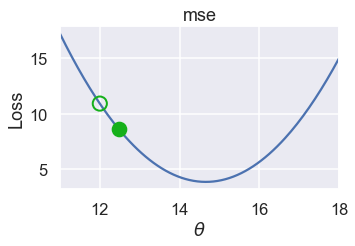

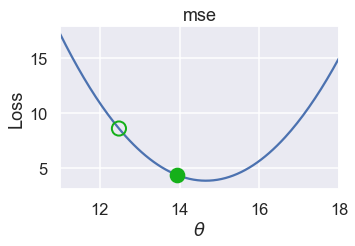

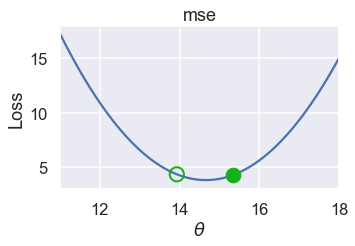

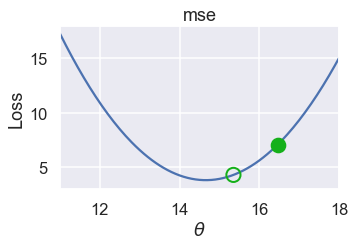

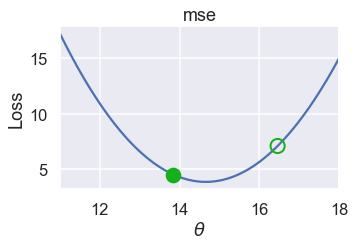

In [348]:
np.random.seed(100)
plot_sgd_epoch(pts, start, mse, grad_mse_one)

## GD Considerations

In [356]:
def mae(pts, theta):
    return np.mean(np.abs(pts - theta))

In [357]:
def grad_mae(pts, theta):
    return np.mean(np.sign(pts - theta))

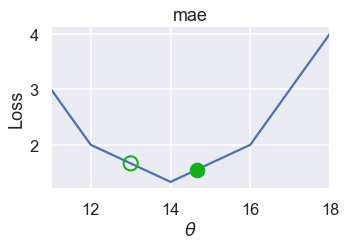

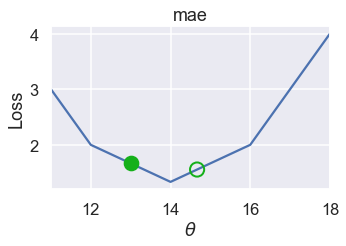

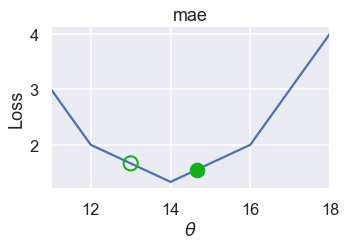

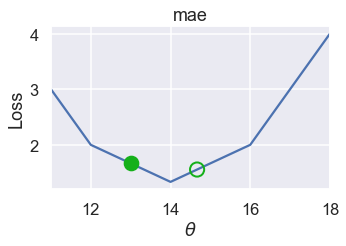

In [364]:
pts = np.array([12, 14, 16])
start = 13
alpha = 5
plot_n_gd_iter(4, pts, start, mae, grad_mae, alpha)